In [68]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import gamma, gammainc

In [4]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP")

In [7]:
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Real Data Sets\First Tel-Aviv data', 'r')

In [19]:
f.keys()

<KeysViewHDF5 ['t', 'wamos', 'x', 'y']>

In [20]:
x = f.get('x')
y = f.get('y')
t = f.get('t')
wamos = f.get('wamos')

x = np.array(x)
y = np.array(y)
t = np.array(t)
wamos = np.array(wamos)

In [26]:
x

array([-247.5 , -243.75, -240.  , -236.25, -232.5 , -228.75, -225.  ,
       -221.25, -217.5 , -213.75, -210.  , -206.25, -202.5 , -198.75,
       -195.  , -191.25, -187.5 , -183.75, -180.  , -176.25, -172.5 ,
       -168.75, -165.  , -161.25, -157.5 , -153.75, -150.  , -146.25,
       -142.5 , -138.75, -135.  , -131.25, -127.5 , -123.75, -120.  ,
       -116.25, -112.5 , -108.75, -105.  , -101.25,  -97.5 ,  -93.75,
        -90.  ,  -86.25,  -82.5 ,  -78.75,  -75.  ,  -71.25,  -67.5 ,
        -63.75,  -60.  ,  -56.25,  -52.5 ,  -48.75,  -45.  ,  -41.25,
        -37.5 ,  -33.75,  -30.  ,  -26.25,  -22.5 ,  -18.75,  -15.  ,
        -11.25,   -7.5 ,   -3.75,    0.  ,    3.75,    7.5 ,   11.25,
         15.  ,   18.75,   22.5 ,   26.25,   30.  ,   33.75,   37.5 ,
         41.25,   45.  ,   48.75,   52.5 ,   56.25,   60.  ,   63.75,
         67.5 ,   71.25,   75.  ,   78.75,   82.5 ,   86.25,   90.  ,
         93.75,   97.5 ,  101.25,  105.  ,  108.75,  112.5 ,  116.25,
        120.  ,  123

In [92]:
t.shape

(366,)

In [22]:
wamos.shape

(366, 132, 132)

In [31]:
y[4] - y[5]

-3.75

In [40]:
dx = x[1] - x[0]
dy = y[1] - y[0]
dt = t[1] - t[0]

In [44]:
wamos.shape

(366, 132, 132)

In [46]:
dk = 2*np.pi/(dx*min(wamos.shape[0], wamos.shape[1]))
dk

0.01269330365086785

In [48]:
wavenumbers = np.arange(3 * dk, 0.35, dk)
wavenumbers

array([0.03807991, 0.05077321, 0.06346652, 0.07615982, 0.08885313,
       0.10154643, 0.11423973, 0.12693304, 0.13962634, 0.15231964,
       0.16501295, 0.17770625, 0.19039955, 0.20309286, 0.21578616,
       0.22847947, 0.24117277, 0.25386607, 0.26655938, 0.27925268,
       0.29194598, 0.30463929, 0.31733259, 0.33002589, 0.3427192 ])

# 1.1) NSP Method

In [50]:
maxFrequency = 4.0 

kW = 1*dk
# Half width of wavenumbers bins [rad/m]

frequencyLimits = [0.01,20.0]
# frequency limits for masking the spectrum [min max], rad/sec

Ux_limits = [-1.0, 1.0]
# Ux current limits [m/s]

Uy_limits = [-1.0, 1.0]
# Uy current limts [m/s]

U_res = 0.1
# Current step size [m/s]

omegaWidthFun = lambda k: 0.05 + 0.0 * k

In [51]:
Uym, Uxm = np.meshgrid(np.arange(min(Uy_limits), max(Uy_limits) + U_res, U_res),
                       np.arange(min(Ux_limits), max(Ux_limits) + U_res, U_res))

In [52]:
h = np.inf
g = 9.81
T = 0.072 / 1000

In [53]:
from scipy.fftpack import fftn, fftshift

def retrieve_power_spectrum(IMG_3D, dx, dy, dt, K_limits=None, W_limits=None):
    # Set default values for K_limits and W_limits if not provided
    if K_limits is None:
        K_limits = [-np.inf, np.inf]
    if W_limits is None:
        W_limits = [-np.inf, np.inf]

    # Check limits
    if any(np.array(K_limits) < 0):
        print('retrieve_positive_spectrum: K_limits smaller than 0')
    if any(np.array(W_limits) < 0):
        print('retrieve_positive_spectrum: W_limits smaller than 0')

    # Get Kx, Ky, and w axes
    Nt, Nx, Ny = IMG_3D.shape
    Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1)
    Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1)
    w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1)

    dKx = Kx[1] - Kx[0]
    dKy = Ky[1] - Ky[0]
    dW = w[1] - w[0]
    Norm = dKx * dKy * dW

    # Get power spectra
    Spectrum_raw = fftshift(fftn(IMG_3D) / np.prod(IMG_3D.shape))
    power_Spectrum = np.abs(Spectrum_raw / Norm)**2

    # Get index boundaries
    ind_x = np.abs(Kx) <= K_limits[1]
    ind_y = np.abs(Ky) <= K_limits[1]
    ind_w = (w >= W_limits[0]) & (w <= W_limits[1])

    # Create 3D structure using meshgrid
    W_3D, Kx_3D, Ky_3D = np.meshgrid(w[ind_w], Kx[ind_x], Ky[ind_y], indexing='ij')

    # Use np.ix_ for boolean indexing to extract the desired values
    power_Spectrum_cut = power_Spectrum[np.ix_(ind_w, ind_x, ind_y)]

    # Set to NaN values outside K_limits
    K_3D = np.sqrt(Kx_3D**2 + Ky_3D**2)
    power_Spectrum_cut[(K_3D < K_limits[0]) | (K_3D > K_limits[1])] = np.nan

    # Get original spectrum limits
    Kx_orig_limits = [Kx[0], Kx[-1]]
    Ky_orig_limits = [Ky[0], Ky[-1]]
    W_orig_limits = [w[0], w[-1]]

    # Normalize spectra (sum(power_Spectrum_cut(:)) = 1)
    power_Spectrum_cut /= np.nansum(power_Spectrum_cut)

    # Create output structure
    Spectrum = {'power_Spectrum': power_Spectrum_cut,
                'Kx_3D': Kx_3D, 'Ky_3D': Ky_3D, 'W_3D': W_3D,
                'dKx': dKx, 'dKy': dKy, 'dW': dW,
                'Kx_orig_limits': Kx_orig_limits, 'Ky_orig_limits': Ky_orig_limits,
                'W_orig_limits': W_orig_limits}

    return Spectrum

In [54]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def get_doppler_shift_velocities_nsp(Spectrum, fit_param, Properties, verboseFig=False):
    
    out_fit = {'wavenumbers': fit_param['wavenumbers'],
               'Ux': np.zeros(len([fit_param['wavenumbers']])),
               'Uy': np.zeros(len([fit_param['wavenumbers']])),
               'SNR_max': np.zeros(len([fit_param['wavenumbers']])),
               'Ux_2D': fit_param['Ux_2D'],
               'Uy_2D': fit_param['Uy_2D'],
               'verbose': []}

    h = Properties['h']
    g = Properties['g']
    T = Properties['T']
    omegaWidthFun = fit_param['omegaWidthFun']
    wavenumbers = fit_param['wavenumbers']

    for jj in range(len([fit_param['wavenumbers']])):
        P = {'h': h, 'g': g, 'T': T,
             'omegaWidth': omegaWidthFun(wavenumbers)}

        snrG = np.zeros(fit_param['Ux_2D'].shape)

        for i in range(fit_param['Ux_2D'].shape[0]):
            for j in range(fit_param['Ux_2D'].shape[1]):
                snr_ij, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers, fit_param['Ux_2D'][i, j], fit_param['Uy_2D'][i, j])
                snrG[i, j] = snr_ij

        im = np.argmax(snrG)

        if np.ndim(fit_param['Ux_2D']) == 1:
            cDoppGuess = fit_param['Ux_2D'][im]
        else:
            cDoppGuess = [fit_param['Ux_2D'].flat[im], fit_param['Uy_2D'].flat[im]]

        options = {'disp': False}  # Turn off display output
        Ufit = minimize(lambda U: 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0] if np.ndim(U) > 1 else 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0], 
                        cDoppGuess, options=options)

        if len(cDoppGuess) > 1:
            Ufit = Ufit.x
        else:
            Ufit = [Ufit.x[0], 0]

        SNR_fit, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers, Ufit[0], Ufit[1])

        out_fit['Ux'][jj] = Ufit[0]
        out_fit['Uy'][jj] = Ufit[1]
        out_fit['SNR_max'][jj] = SNR_fit

        verbose = {'k': fit_param['wavenumbers'], 'SNR_2D': snrG, 'Peaks_2D': find_peaks(snrG)}
        out_fit['verbose'].append(verbose)

    # Post-processing
    out_fit['Ux_filt'] = out_fit['Ux'].copy()
    out_fit['Uy_filt'] = out_fit['Uy'].copy()
    out_fit['SNR_max'] = out_fit['SNR_max'].copy()

    return out_fit

In [55]:
def nsp_doppler_shift_extraction(Spectrum, params, kval, U, V):
    # Define wave dispersion relation.
    omegaFun = lambda kx, ky: np.sqrt((params['g']*np.sqrt(kx**2 + ky**2) + params['T']*np.sqrt(kx**2 + ky**2)**3) * np.tanh(np.sqrt(kx**2 + ky**2) * params['h'])) + U*kx + V*ky

    # Frequency width of weighting function (1/e^2 halfwidth)
    a = params['omegaWidth']

    if 'logFlag' not in params:
        params['logFlag'] = 0

    if 'include2ndHarmonic' not in params:
        params['include2ndHarmonic'] = 0

    if 'kWidth' in params:
        a_k = params['kWidth']
    else:
        a_k = max(Spectrum['dKx'], Spectrum['dKy']) * 2

    inds = ~np.isnan(Spectrum['power_Spectrum'])

    P_k = np.sqrt(Spectrum['power_Spectrum'][inds])
    KX = Spectrum['Kx_3D'][inds]
    KY = Spectrum['Ky_3D'][inds]
    W = Spectrum['W_3D'][inds]

    if params['include2ndHarmonic']:
        inds2 = ~np.isnan(Spectrum['power_Spectrum2'])
        P_k2 = np.sqrt(Spectrum['power_Spectrum2'][inds2])
        KX2 = Spectrum['Kx_3D2'][inds2]
        KY2 = Spectrum['Ky_3D2'][inds2]
        W2 = Spectrum['W_3D2'][inds2]
        omegaFun2 = lambda kx, ky: np.sqrt(2) * np.sqrt((params['g']*np.sqrt(kx**2 + ky**2) + params['T']*np.sqrt(kx**2 + ky**2)**3) * np.tanh(np.sqrt(kx**2 + ky**2) * params['h']) + U*kx + V*ky)
    else:
        P_k2 = 0

    if params['logFlag']:
        P_k = np.log(P_k)
        P_k = P_k - np.min(P_k)

        if params['include2ndHarmonic']:
            P_k2 = np.log(P_k2)
            P_k2 = P_k2 - np.min(P_k2)

    K = np.sqrt(KX**2 + KY**2)
    order = 2

    if not np.isnan(kval):
        P_k = P_k * np.exp(-2*((K-kval)/a_k)**order)

    # Define weighting function G
    G1 = np.exp(-2*((W - omegaFun(KX, KY))/max(a))**order)
    G2 = np.exp(-2*((W + omegaFun(-KX, -KY))/max(a))**order)

    G = G1 + G2

    if params['include2ndHarmonic']:
        G1_2 = np.exp(-2*((W2 - omegaFun2(KX2, KY2))/a)**order)
        G2_2 = np.exp(-2*((W2 + omegaFun2(-KX2, -KY2))/a)**order)

        G_2 = G1_2 + G2_2

        P_k2[~np.isfinite(P_k2)] = 0

        signal_2 = np.sum(P_k2*G_2)/np.sum(G_2)
        noise_2 = np.sum(P_k2*(1-G_2))/np.sum(1-G_2)
    else:
        signal_2 = 0
        noise_2 = 0

    P_k[~np.isfinite(P_k)] = 0
    InP = P_k * G

    signal_1 = np.sum(InP)/np.sum(G)
    noise_1 = np.sum(P_k*(1-G))/np.sum(1-G)
    SNR = (signal_1 + signal_2)/(noise_1 + noise_2)

    return SNR, P_k, G

In [56]:
wavenumberLimits = []

for jj in range(len(wavenumbers)):
    wavenumberLimits_range = wavenumbers[jj] + kW * np.array([-1,1])
    wavenumberLimits.append(wavenumberLimits_range)

In [58]:
Spectrum_at_k = []

ind_x_at_k = []
ind_y_at_k = []
ind_w_at_k = []

W_3D_at_k = []
Kx_3D_at_k = []
Ky_3D_at_k = []

Ux_at_k = []
Uy_at_k = []

SNR_max_at_k = []

snrG_at_k = []

im_at_k = []
cDoppGuess_at_k = []

Ux_at_k_correct = []
Uy_at_k_correct = []

# Initialize the tqdm progress bar outside the loop
progress_bar = tqdm(total=len(wavenumberLimits), desc="Processing wavenumbers")

for i in range(len(wavenumberLimits)):
    # i is the index of each wavenumber
    
    fit_param = {'wavenumbers': wavenumbers[i],
     'include2ndHarmonic': 0,
     'logFlag': [],
     'SNR_filter': 0,
     'SNR_threshold': 1.0,
     'Peak_filter': 0,
     'Peak_threshold': 0.5,
     'Outlier_filter': 0,
     'kWidth': 0.050015405430285265,
     'Ux_2D': Uxm, 
     'Uy_2D': Uym}
    
    P = {'h': h, 'g': g, 'T': T,
             'omegaWidth': omegaWidthFun(wavenumbers),
             'kWidth': fit_param['kWidth'],
             'logFlag': fit_param['logFlag'],
             'include2ndHarmonic': fit_param['include2ndHarmonic']}
    
    Spectrum = retrieve_power_spectrum(wamos, dx, dy, dt, K_limits=wavenumberLimits[i], W_limits=frequencyLimits)
    Spectrum_at_k.append(Spectrum)
    
    Nt, Nx, Ny = wamos.shape
    
    Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) # 67 values
    Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) # 67 Values
    w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1) # 1200 Values
    # w = spec3d.get_C()[0]
    # Kx = spec3d.get_C()[1]
    # Ky = spec3d.get_C()[2]
    
    dKx = Kx[1] - Kx[0]
    dKy = Ky[1] - Ky[0]
    dW = w[1] - w[0]
    # kx, ky and w resolution
    
    Norm = dKx * dKy * dW
    
    # Get power spectra (1200, 67, 67)
    Spectrum_raw = fftshift(fftn(wamos) / np.prod(wamos.shape))
    power_Spectrum = np.abs(Spectrum_raw / Norm)**2
    # ?? how is this related to FFT spec3d.spectrum()
    
    ind_x = np.abs(Kx) <= wavenumberLimits[i][1]
    ind_x_at_k.append(ind_x)
    ind_y = np.abs(Ky) <= wavenumberLimits[i][1]
    ind_y_at_k.append(ind_y)
    # Is the absolute values of Kx and Ky smaller than the upper value of the wavenumber range 
    
    ind_w = (w >= frequencyLimits[0]) & (w <= frequencyLimits[1])
    ind_w_at_k.append(ind_w)
    # Is the value of w between the frequency limits 0.01 and 20 
    
    # Create 3D structure where it only includes w,Kx,Ky that are in the ranges required by wavenumberLimits
    W_3D, Kx_3D, Ky_3D = np.meshgrid( w[ind_w_at_k[i]], Kx[ind_x_at_k[i]] , Ky[ind_y_at_k[i]] , indexing='ij')
    W_3D_at_k.append(W_3D)
    Kx_3D_at_k.append(Kx_3D)
    Ky_3D_at_k.append(Ky_3D)
    
    
    Ux_2D = Uxm
    Uy_2D = Uym
    
    snrG = np.zeros(Ux_2D.shape)
    
    for m in range(Ux_2D.shape[0]):
        for n in range(Ux_2D.shape[1]):
            snr_mn, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers[i], Ux_2D[m, n], Uy_2D[m, n])
            snrG[m, n] = snr_mn
            
            
    snrG_at_k.append(snrG)
    # Append the 2D array to the list
    
    
    im = np.argmax(snrG_at_k[i])
    im_at_k.append(im)
    
    if np.ndim(Ux_2D) == 1:
        cDoppGuess = Ux_2D[im]
    else:
        Ux_1D = Ux_2D.flatten()
        Uy_1D = Uy_2D.flatten()
        cDoppGuess = [Ux_1D[im], Uy_1D[im]]
    
    cDoppGuess_at_k.append(cDoppGuess)
    
    
    Ufit = minimize(lambda U: 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0], cDoppGuess)
    
    Ux = Ufit.x[0]
    Uy = Ufit.x[1]
    
    Ux_at_k_correct.append(Ux)
    Uy_at_k_correct.append(Uy)
    
    # Update the tqdm progress bar
    progress_bar.update(1)

# Close the tqdm progress bar after the loop is finished
progress_bar.close()

Processing wavenumbers: 100%|██████████| 25/25 [01:34<00:00,  3.76s/it]


In [59]:
Ux = np.array(Ux_at_k_correct)
Uy = np.array(Uy_at_k_correct)

(-4.0, 4.0)

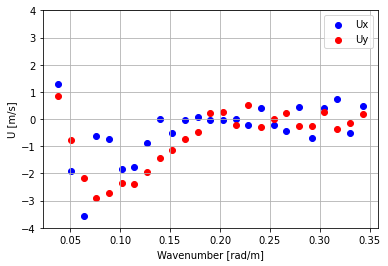

In [127]:
plt.scatter(wavenumbers, -Ux, label='Ux', color = 'blue')
plt.scatter(wavenumbers, Uy, label='Uy', color = 'red')
#plt.plot(k, Uk[:,0], label = 'Correct U', linestyle='--', color='black')


plt.grid(True)
plt.legend()
plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")

plt.ylim(-4, 4)
#plt.xlim(0, 0.31)

# 2.1) Inverted Profile

In [225]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.special import factorial, gammaincc, gamma
from numpy.polynomial import Polynomial

def rms(x):
    return np.sqrt(np.mean(x**2))

def pedm(k_vect, c_til, nMax_vals=None, deltaz_T_vals=None, deltaz_B_vals=None, waterDepth=None):

    # If user has not provided information about the waterDepth, set to infinity
    if waterDepth is None:
        waterDepth = np.inf

    # Handling for inadequate input data.
    if len(k_vect) == 0 or len(c_til) == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    # Now we start with the PEDM. The steps follow those in the manuscript in section 2.1.2 Effect of limitations of measured Doppler shifts
    # Define the parameters.
    # Calculate effective depths of Doppler shift velocities based on assumption of a linear profile
    Z_eff = -(2 * k_vect) ** -1 * np.tanh(np.abs(waterDepth) * k_vect)

    # Set default values for PEDM parameter combinations if inputs left blank
    if nMax_vals is None:
        nm = min(12, round(len(k_vect) / 2))
        nMax_vals = np.arange(0, nm+1)
    
    if deltaz_T_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_T_vals = np.linspace(0.01, 0.2, 20) * depthRange

    if deltaz_B_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_B_vals = np.linspace(0.02, 0.8, 20) * depthRange

    z_c = max(4 * np.min(Z_eff), -np.abs(waterDepth))  # Cutoff depth chosen as 4 times the deepest mapped depth. (Set to water depth if depth is shallower)
    # z_c is NEGATIVE by convention here

    # We loop over all PEDM parameter combinations. First initialize eps_PEDM_out as well as the other outputs.
    eps_PEDM_out = np.inf
    eps_EDM_out = np.inf

    pPEDM_out = np.nan
    pEDM_out = np.nan

    verbose = []
    combo = 0

    for nMax in nMax_vals:
        for deltaz_B in deltaz_B_vals:
            for deltaz_T in deltaz_T_vals:
                # STEP 1: Fit the mapped Doppler shifts to a polynomial of order nMax.
                p1 = np.polyfit(Z_eff, c_til, nMax)

                # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
                zB = np.linspace(0, deltaz_B, 100)
                zT = np.linspace(-deltaz_T, 0, 100)

                pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
                pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

                depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B)
                depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T, 0, deltaz_T), [0]))

                zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
                cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

                # STEP 3: Perform a second polynomial fit on the expanded set of points
                pEDM = np.polyfit(zEx, cTilEx, nMax)

                # Determine if profile is monotonic with range of mapped depths.
                nv = np.arange(nMax, 0, -1)
                pczEx_p = nv * pEDM[:-1]  # Derivative polynomial coefficients
                rts = np.roots(pczEx_p)  # Find roots
                rts = rts[np.isreal(rts)]  # Discard complex roots

                # If there roots of the derivative within ranges of mapped depths, don't go further.
                if np.any((rts > Z_eff[0]) & (rts < 0)):
                    continue

                # STEP 4: Scale polynomial coefficients defining U_EDM by n! as in equation (8) in the article.
                pPEDM_i = pEDM / factorial(np.arange(nMax, -1, -1))

                # STEP 5: Create a new set of linearly extrapolated points down to z_c based on the average shear of the above polynomial function in a depth interval deltaz_B/2 at the deep end of the regime.
                zB2 = np.linspace(0, deltaz_B/2, 100)
                pBottom2 = np.polyfit(Z_eff[0] + zB, np.polyval(pPEDM_i, Z_eff[0] + zB), 1)

                depthsExBtm2 = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B/2)

                zEx2 = np.concatenate((depthsExBtm2, Z_eff, depthsExTop))
                Uvals = np.concatenate((np.polyval(pBottom2, depthsExBtm2), np.polyval(pPEDM_i, Z_eff), np.polyval(pPEDM_i, depthsExTop)))

                # STEP 6: Perform a final polynomial fit on the expanded set of points.
                pPEDM = np.polyfit(zEx2, Uvals, nMax)

                # Calculate Doppler shifts assuming U_EDM or U_PEDM as the current profile, using the forward problem.
                c_tilEDM = 0
                c_tilPEDM = 0

                if nMax < 2:
                    for n in range(nMax + 1):
                        c_tilEDM = c_tilEDM + factorial(n) * pEDM[-n-1] * (-1 / (2 * k_vect)) ** n
                        c_tilPEDM = c_tilPEDM + factorial(n) * pPEDM[-n-1] * (-1 / (2 * k_vect)) ** n
                else:
                    for n in range(nMax + 1):
                        c_tilEDM = c_tilEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)
                        c_tilPEDM = c_tilPEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pPEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)

                # Calculate RMS differences (equation (9) in manuscript)
                eps_EDM = rms(c_til - c_tilEDM)  # RMS difference for U_EDM
                eps_PEDM = rms(c_til - c_tilPEDM)  # RMS difference for U_PEDM.

                # Parameters nMax, deltaz_T, and deltaz_B are chosen to minimize eps_PEDM in practice.
                if eps_PEDM < eps_PEDM_out:
                    eps_PEDM_out = eps_PEDM
                    pPEDM_out = pPEDM
                    nMax_out = nMax
                    deltaz_B_out = deltaz_B
                    deltaz_T_out = deltaz_T

                if eps_EDM < eps_EDM_out:
                    eps_EDM_out = eps_EDM
                    pEDM_out = pEDM

                combo = combo + 1
                verbose.append({
                    #'pPEDM': pPEDM.tolist(),
                    #'pEDM': pEDM.tolist(),
                    'pPEDM': pPEDM,
                    'pEDM': pEDM,
                    'eps_PEDM': eps_PEDM,
                    'eps_EDM': eps_EDM,
                    'nMax': nMax,
                    'deltaz_B': deltaz_B,
                    'deltaz_T': deltaz_T
                })

                
                #return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose
    return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose

# Example usage:
pPEDM1, pEDM1, eps_PEDM1, eps_EDM1, verbose1 = pedm(wavenumbers,matlab_ux)
pPEDM2, pEDM2, eps_PEDM2, eps_EDM2, verbose2 = pedm(wavenumbers, Uy)

## Testing

In [182]:
z_c = max(4 * np.min(Z_eff), -np.abs(np.inf))
z_c

-52.521131220325465

In [214]:
p1 = np.polyfit(Z_eff, -Ux, 3)
p1

array([-0.01184041, -0.17444656, -0.35421032, -0.07098805])

In [209]:
-Ux

array([ 1.29355558, -1.89302305, -3.58112691, -0.61458953, -0.72034137,
       -1.83565928, -1.77717671, -0.86307236,  0.01816371, -0.52742614,
       -0.02743893,  0.07271172, -0.03647709, -0.04848306, -0.01043948,
       -0.21775304,  0.39744131, -0.20223908, -0.44201397,  0.43091857,
       -0.70061823,  0.39973644,  0.73059773, -0.52339084,  0.4993682 ])

In [206]:
Z_eff

array([-13.13028281,  -9.8477121 ,  -7.87816968,  -6.5651414 ,
        -5.62726406,  -4.92385605,  -4.37676094,  -3.93908484,
        -3.58098622,  -3.2825707 ,  -3.03006526,  -2.81363203,
        -2.62605656,  -2.46192803,  -2.31710873,  -2.18838047,
        -2.07320255,  -1.96954242,  -1.87575469,  -1.79049311,
        -1.71264558,  -1.64128535,  -1.57563394,  -1.51503263,
        -1.45892031])

In [207]:
Ux

array([-1.29355558,  1.89302305,  3.58112691,  0.61458953,  0.72034137,
        1.83565928,  1.77717671,  0.86307236, -0.01816371,  0.52742614,
        0.02743893, -0.07271172,  0.03647709,  0.04848306,  0.01043948,
        0.21775304, -0.39744131,  0.20223908,  0.44201397, -0.43091857,
        0.70061823, -0.39973644, -0.73059773,  0.52339084, -0.4993682 ])

In [196]:
Z_eff

array([-13.13028281,  -9.8477121 ,  -7.87816968,  -6.5651414 ,
        -5.62726406,  -4.92385605,  -4.37676094,  -3.93908484,
        -3.58098622,  -3.2825707 ,  -3.03006526,  -2.81363203,
        -2.62605656,  -2.46192803,  -2.31710873,  -2.18838047,
        -2.07320255,  -1.96954242,  -1.87575469,  -1.79049311,
        -1.71264558,  -1.64128535,  -1.57563394,  -1.51503263,
        -1.45892031])

In [201]:
Ux

array([-1.29355558,  1.89302305,  3.58112691,  0.61458953,  0.72034137,
        1.83565928,  1.77717671,  0.86307236, -0.01816371,  0.52742614,
        0.02743893, -0.07271172,  0.03647709,  0.04848306,  0.01043948,
        0.21775304, -0.39744131,  0.20223908,  0.44201397, -0.43091857,
        0.70061823, -0.39973644, -0.73059773,  0.52339084, -0.4993682 ])

In [220]:
Ux.shape

(25,)

In [222]:
wavenumbers.shape

(25,)

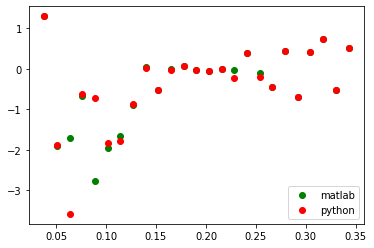

In [224]:
plt.scatter(wavenumbers, matlab_ux, label='matlab', color = 'green')
plt.scatter(wavenumbers, -Ux, label='python', color = 'red')

plt.legend()

In [215]:
matlab_ux = np.array([1.29324047095870, -1.89463189363109, -1.69708851869363, -0.669636210830390, -2.75906065502856, -1.94768284605381, -1.66698298781537, -0.899800584589916, 0.0297085589908087, -0.514835078702308, -0.0105890842080116, 0.0759766804549144, -0.0363850496987580, -0.0484059195965528, -0.0103916622911056, -0.0308550721930313, 0.398842029692605, -0.117723340988159, -0.441378683422372, 0.430707406907151, -0.699842772060439, 0.399538248189037, 0.730470696764732, -0.523203395681584, 0.499213099684858])

In [217]:
p1 = np.polyfit(Z_eff, matlab_ux, 3)
p1

array([-0.00661969, -0.06422495,  0.25762861,  0.75927628])

In [226]:
z = np.linspace(-20, 0, 100)

In [227]:
U1_fun = lambda z: np.polyval(pPEDM1, z)
U2_fun = lambda z: np.polyval(pPEDM2, z)

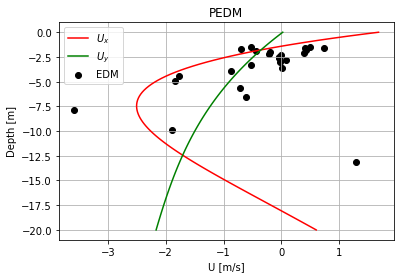

In [228]:
plt.plot(U1_fun(z), z, label="$U_{x}$", color = 'red')
plt.plot(U2_fun(z), z, label="$U_{y}$", color = 'green')

plt.scatter(-Ux, -1/(2*wavenumbers), label='EDM', color = 'black')
#plt.scatter(-Ux, -1/(3.56*wavenumbers), label='EDM', color = 'red')

plt.grid(True)
plt.title("PEDM")
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()

In [169]:
len(verbose1)

1066

In [162]:
pPEDM1

array([ 0.10510466, -0.01111033])

In [161]:
verbose1[0]

{'pPEDM': array([-0.40715103]),
 'pEDM': array([-0.40715103]),
 'eps_PEDM': 0.994583690542734,
 'eps_EDM': 0.994583690542734,
 'nMax': 0,
 'deltaz_B': 0.2334272498681132,
 'deltaz_T': 0.1167136249340566}